# Vehicle Detection Inference

Load the trained YOLO model and perform inference on new images

In [1]:
# Import required libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

# Load class names from the data configuration
import yaml
with open('vehicle-detection.v21i.yolov11/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    
print("Available classes:", data_config['names'])

Available classes: ['mobil', 'motor']


In [2]:
# Load the trained model
model_path = 'runs/detect/train5/weights/best.pt'  # Path to the best weights from training
model = YOLO(model_path)

print("Model loaded successfully!")

Model loaded successfully!


In [6]:
# Function to process image and display results
def detect_vehicles(image_path, conf_threshold=0.25):
    """
    Detect and count vehicles in an image
    """
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Run inference
    results = model.predict(img, conf=conf_threshold)[0]
    
    # Initialize counters
    counts = {'mobil': 0, 'motor': 0, 'total': 0}
    
    # Process detections
    for box in results.boxes:
        conf = float(box.conf)
        if conf < conf_threshold:
            continue
            
        cls = int(box.cls)
        class_name = data_config['names'][cls]
        counts[class_name] += 1
        counts['total'] += 1
        
        # Draw bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        color = (0, 255, 0) if class_name == 'mobil' else (255, 0, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        label = f"{class_name} {conf:.2f}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add count summary
    summary = f"Total: {counts['total']} | Cars: {counts['mobil']} | Motorcycles: {counts['motor']}"
    cv2.putText(img, summary, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display results
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Vehicle Detection Results')
    plt.show()
    
    print("\nDetection Results:")
    print(f"Total vehicles: {counts['total']}")
    print(f"Cars: {counts['mobil']}")
    print(f"Motorcycles: {counts['motor']}")
    
    return counts


0: 416x288 6 mobils, 92.8ms
Speed: 7.4ms preprocess, 92.8ms inference, 5.1ms postprocess per image at shape (1, 3, 416, 288)


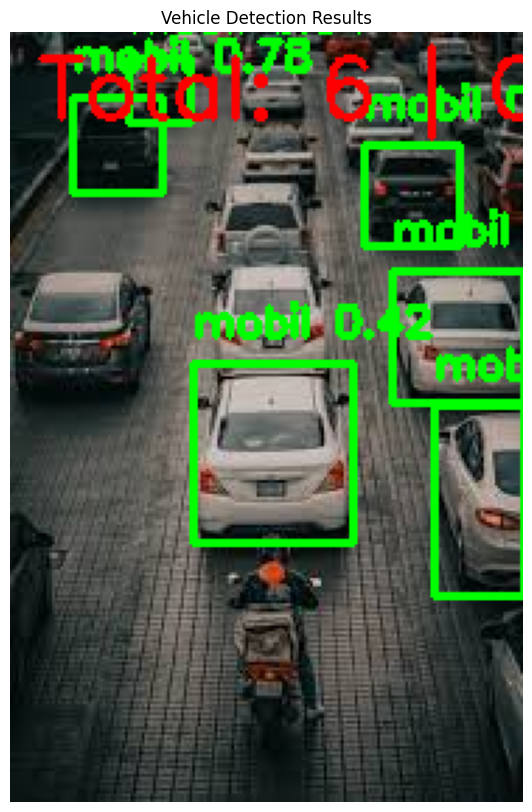


Detection Results:
Total vehicles: 6
Cars: 6
Motorcycles: 0


{'mobil': 6, 'motor': 0, 'total': 6}

In [7]:
# Test on the specified image
image_path = 'images1.jpeg'
detect_vehicles(image_path)